<a href="https://colab.research.google.com/github/naoya1110/DL_Lecture_202107/blob/main/Introduction_to_Image_Classification_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像分類AI超ざっくり入門

## イントロダクション
うどんの写真からどこのうどん屋か当てる画像分類AIを作ってみましょう。

### GPU

GPUが使える状態であることを確認します。

In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


### 基本のPythonパッケージ

必要なPythonパッケージをインポートします。

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
import gdown
import random

## データの準備

### udon10_datasetのダウンロード

以下のセルを実行することでudon10_dataset.zipがダウンロードされ，さらに解凍されます。

In [3]:
gdown.download('https://drive.google.com/uc?id=16FSxLAMVDppr7kF8rrFHCWO0fNLJOsxt', 'udon10_dataset.zip', quiet = False)
! unzip udon10_dataset.zip > /dev/null 2>&1

Downloading...
From: https://drive.google.com/uc?id=16FSxLAMVDppr7kF8rrFHCWO0fNLJOsxt
To: /content/udon10_dataset.zip
100%|██████████| 990M/990M [00:13<00:00, 71.5MB/s]


udon10_datasetに含まれるデータの数を見てみましょう。

In [4]:
dataset_dir = "udon10_dataset"
for subdir in ["train", "valid"]:
    print(subdir)
    subsubdirs = sorted(os.listdir(os.path.join(dataset_dir, subdir)))
    for subsubdir in subsubdirs:
        filenames = os.listdir(os.path.join(dataset_dir, subdir, subsubdir))
        print("---", subsubdir, ":", len(filenames))

train
--- 0000_nagata-in-kanoka_zentsuji : 1000
--- 0001_udon-bakaichidai_takamatsu : 1000
--- 0002_yamagoe-udon_ayagawa : 1000
--- 0003_gamou_sakaide : 1000
--- 0004_hinode-seimenjo_sakaide : 1000
--- 0005_ippuku_takamatsu : 1000
--- 0006_moriya_takamatsu : 1000
--- 0007_yoshiya_marugame : 1000
--- 0008_sakaeda_takamatsu : 1000
--- 0009_yamadaya_takamatsu : 1000
valid
--- 0000_nagata-in-kanoka_zentsuji : 50
--- 0001_udon-bakaichidai_takamatsu : 50
--- 0002_yamagoe-udon_ayagawa : 50
--- 0003_gamou_sakaide : 50
--- 0004_hinode-seimenjo_sakaide : 50
--- 0005_ippuku_takamatsu : 50
--- 0006_moriya_takamatsu : 50
--- 0007_yoshiya_marugame : 50
--- 0008_sakaeda_takamatsu : 50
--- 0009_yamadaya_takamatsu : 50


### Datasetオブジェクトの作成
以下のセルを実行し学習用とテスト用のDatasetオブジェクトを作成します。

In [5]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root=f"{dataset_dir}/train")
test_dataset = ImageFolder(root=f"{dataset_dir}/valid")

print("train_dataset:", len(train_dataset))
print("test_dataset:", len(test_dataset))

train_dataset: 10000
test_dataset: 500


train_datasetからいくつか画像を表示して確認してみましょう。

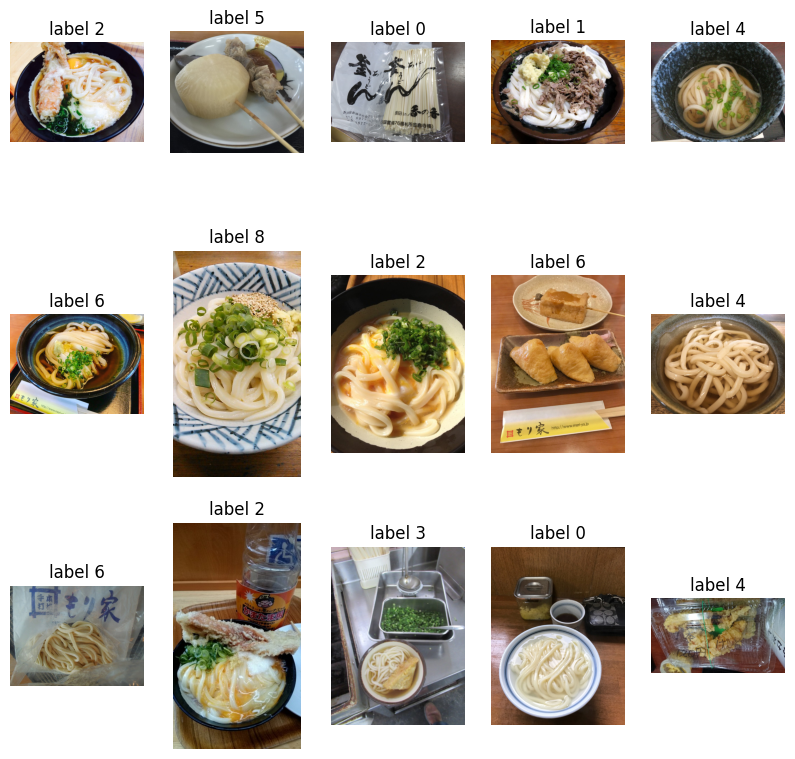

In [6]:
plt.figure(figsize=(10, 10))

for i in range(15):
    image, label = train_dataset[random.randint(0, len(train_dataset))]
    plt.subplot(3, 5, i+1)
    plt.imshow(image)
    plt.title(f"label {label}") 
    plt.axis("off")

ラベルの番号とうどん屋の名前（フォルダ名）の関係は次のようになっています。

In [8]:
classnames = {value: key[5:] for key, value in train_dataset.class_to_idx.items()}
classnames

{0: 'nagata-in-kanoka_zentsuji',
 1: 'udon-bakaichidai_takamatsu',
 2: 'yamagoe-udon_ayagawa',
 3: 'gamou_sakaide',
 4: 'hinode-seimenjo_sakaide',
 5: 'ippuku_takamatsu',
 6: 'moriya_takamatsu',
 7: 'yoshiya_marugame',
 8: 'sakaeda_takamatsu',
 9: 'yamadaya_takamatsu'}

AIのモデルに画像を入力するためにはすべての画像が同じサイズでなければなりません。
そこで再度サイズを指定してDatasetオブジェクトを作ります。

In [9]:
from torchvision import transforms

size=128

train_dataset = ImageFolder(root=f"{dataset_dir}/train",
                            transform=transforms.Compose([
                                transforms.Resize((size, size)),
                                transforms.ToTensor()
                                ])
                       )

test_dataset = ImageFolder(root=f"{dataset_dir}/valid",
                           transform=transforms.Compose([
                                transforms.Resize((size, size)),
                                transforms.ToTensor()
                                ])
                      )

### データの分離
一般的に学習用データ(train_dataset)はそのすべて学習に使用するのではなく，その一部を学習途中の検証用データ(valid_dataset)として使用します。

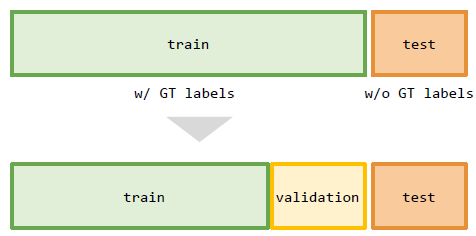

In [10]:
from torch.utils.data import random_split

n_samples = len(train_dataset)
train_size = int(n_samples * 0.8)    # 80% will be training data
valid_size = n_samples - train_size  # 20% will be validation data

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

print("train data", len(train_dataset))
print("validation data", len(valid_dataset))

train data 8000
validation data 2000


### DataLoader

AIモデルにデータを入力するためのDataLoaderオブジェクトを作ります。

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=50, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=2)

## AIモデルの作成

### VGG16

In [13]:
import torch.nn as nn
import torchvision.models as models

def create_vgg16(outputs=10, freeze=False):
    model = models.vgg16(pretrained=True)

    if freeze:
        for param in model.parameters():
            param.requires_grad = False  

    model.classifier[6] = nn.Linear(4096, outputs)   # replace the last layer
    return model

model = create_vgg16(outputs=len(classnames), freeze=False)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### ResNet50

In [14]:
def create_resnet50(outputs=10, freeze=False):
    model = models.resnet50(pretrained=True)
    
    if freeze:
        for param in model.parameters():
            param.requires_grad = False   
    
    model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, outputs))
    
    return model

model = create_resnet50(outputs=len(classnames), freeze=False)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 226MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## AIモデルの学習/AI Model Training

### 損失関数/Loss Function
AIモデルの出力がどの程度正解から外れているかを評価するための損失関数を定義します。

In [16]:
loss_func = nn.CrossEntropyLoss()

### 最適化関数/Optimizer
AIモデルのパラメータを更新するためのアルゴリズム最適化関数を定義します。

In [17]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1E-3)

### 学習ループ/Training Loop







In [ ]:
#model = create_vgg16(outputs=len(classnames), freeze=True)
model = create_resnet50(outputs=len(classnames), freeze=True)


model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1E-3)    # set optimizer
epochs = 10

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
valid_loss_list = []
valid_accuracy_list = []

for epoch in range(epochs):

    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics value
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    valid_correct_count = 0
    valid_accuracy = 0
    valid_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    pbar = tqdm(train_loader)
    pbar.set_description("Train")

    for x_batch, y_batch in pbar:      # take mini batch data from train_loader
        
        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU
    
        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss
        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        pbar = tqdm(valid_loader)
        pbar.set_description("Valid") 

        for x_batch, y_batch in pbar:   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            valid_loss += loss.item()                                # accumulate loss value
            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            valid_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

            pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #------------------------#

    train_accuracy = train_correct_count.item()/len(train_dataset)   # determine accuracy for training data
    valid_accuracy = valid_correct_count.item()/len(valid_dataset)   # determin accuracy for test data
    train_loss = train_loss/len(train_loader)       # determin loss for training data
    valid_loss = valid_loss/len(valid_loader)       # determin loss for validation data 

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Valid: Accuracy={valid_accuracy:.3f} Loss={valid_loss:.3f}")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    valid_accuracy_list.append(valid_accuracy)
    valid_loss_list.append(valid_loss)
    
    print("---------------------")

Epoch 1/10


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Train: Accuracy=0.525 Loss=1.462, Valid: Accuracy=0.612 Loss=1.194
---------------------
Epoch 2/10


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Train: Accuracy=0.659 Loss=1.067, Valid: Accuracy=0.638 Loss=1.118
---------------------
Epoch 3/10


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Train: Accuracy=0.684 Loss=0.977, Valid: Accuracy=0.655 Loss=1.080
---------------------
Epoch 4/10


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Train: Accuracy=0.703 Loss=0.921, Valid: Accuracy=0.638 Loss=1.092
---------------------
Epoch 5/10


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Train: Accuracy=0.716 Loss=0.867, Valid: Accuracy=0.662 Loss=1.036
---------------------
Epoch 6/10


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Train: Accuracy=0.738 Loss=0.810, Valid: Accuracy=0.654 Loss=1.044
---------------------
Epoch 7/10


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Train: Accuracy=0.746 Loss=0.766, Valid: Accuracy=0.684 Loss=0.994
---------------------
Epoch 8/10


  0%|          | 0/160 [00:00<?, ?it/s]

### 学習曲線/Learning Curves

正解率と損失がどのように変化したかを可視化してみてみましょう。

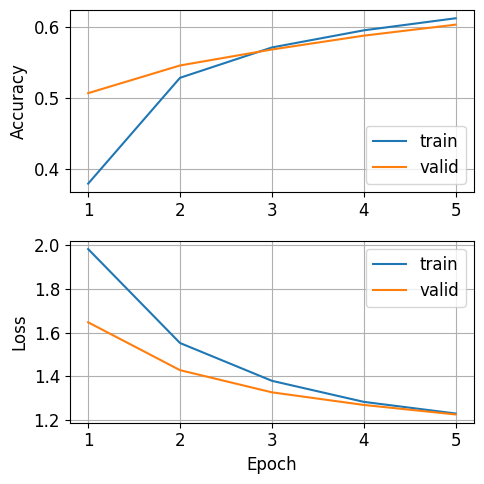

In [ ]:
plt.figure(figsize=(5,5))
plt.rcParams["font.size"]=12

plt.subplot(2,1,1)
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, valid_accuracy_list, label="valid")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, valid_loss_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

plt.tight_layout()

## 学習済みAIモデルの評価/Evaluation of Trained AI Model

### テストデータに対する正解率

In [20]:
test_correct_count = 0

y_test_all = np.array([])
p_label_all = np.array([])

with torch.no_grad():   # disable autograd for saving memory usage
    model.eval()        # set model to evaluation mode

    for x_batch, y_batch in test_loader:      # take mini batch data from test_loader 

        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU
        
        p_batch = model(x_batch)              # do prediction

        p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
        test_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        y_test_all = np.append(y_test_all, y_batch.numpy())          # append y_batch in y_test_all
        p_label_all = np.append(p_label_all, p_batch_label.numpy())  # append p_batch_label in p_label_all

test_accuracy = test_correct_count/len(test_dataset)      # determine accuracy for test data
print(f"Test Accuracy = {test_accuracy:.3f}")

RuntimeError: ignored

### 混同行列/Confusion Matrix

In [19]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_test_all, p_label_all)

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.figure(figsize=(7,6))
labels = list(classnames.values())

sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=labels, yticklabels=labels, square=True)

plt.ylabel("Ground Truth")
plt.xlabel("Prediction")
plt.title("confusion matrix")

500

That's it for this week. Try your best for the image classification competition!